In [1]:
import pandas as pd
import numpy as np
import math
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt

### Caricamento del dataset

In [2]:
data = pd.read_csv("backup_corpus/corpus_intro_final.csv")

In [3]:
corpus = data[['Article Title', 'Abstract', 'Introduction', 'Publication Year', 'Times Cited, All Databases']]

In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Article Title               260 non-null    object
 1   Abstract                    260 non-null    object
 2   Introduction                259 non-null    object
 3   Publication Year            260 non-null    int64 
 4   Times Cited, All Databases  260 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 10.3+ KB


### Rimozione documenti vuoti

In [5]:
corpus = corpus.dropna() #remove nan values
corpus = corpus.reset_index(drop=True) #reset index for removed elements
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Article Title               259 non-null    object
 1   Abstract                    259 non-null    object
 2   Introduction                259 non-null    object
 3   Publication Year            259 non-null    int64 
 4   Times Cited, All Databases  259 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 10.2+ KB


### Aggiunta titolo, introduzione e abstract al corpus

Dopo aver arricchito il dataset contenente i documenti scientifici con le introduzioni, si procede selezionando solamente le feature contenenti informazioni utili per poter estrarre i topic latenti dal corpus. In particolare, per questo studio si è scelto di combinare il titolo, l'abstract e l'introduzione concatenandoli; questa operazione è possibile poichè i modelli per topic trattano il testo come una bag-of-words e, pertanto, l'ordine delle parole è indifferente.

In [6]:
corpus['Abstract'] = corpus.loc[:, 'Article Title'] + ' ' + corpus.loc[:, 'Abstract']

## Descrizione dataset

In [49]:
import seaborn as sns
sns.set_theme()

In [8]:
corpus = corpus.rename(columns={"Publication Year": "Year", "Article Title": "Title", "Times Cited, All Databases": "Citations"})

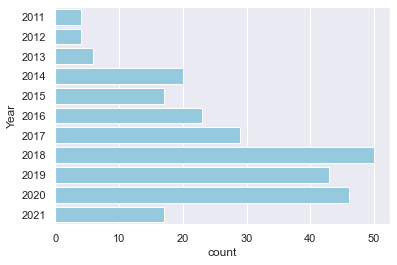

In [50]:
ax = sns.countplot(y="Year", data=corpus, color='skyblue')

### Preprocessing

Tutte le tecniche di NLP (Natural Language Processing) necessitano di una fase preliminare di pulizia dei dati, nella quale si rimuovono le parti di testo che non portano informazione utile ma, anzi, potrebbero peggiorare le prestazioni del modello [inserire riferimento al capitolo sul preprocessing nel software].

Il testo viene preliminarmente trasformato in minuscolo, poi vengono rimossi i numeri e tutti i caratteri speciali, filtrando dunque tutto ciò che non è una parola di linguaggio naturale.

In [10]:
# lowercase
corpus['Abstract'] = corpus['Abstract'].str.lower()

# remove numbers
corpus['Abstract'] = corpus['Abstract'].str.replace(r'[0-9]+', ' ', regex=True)

# remove link
corpus['Abstract'] = corpus['Abstract'].str.replace(r'http\S+', ' ', regex=True)

# remove punctuaction and special characters except dashes
corpus['Abstract'] = corpus['Abstract'].str.replace(r'[^\w\s\-]', ' ', regex=True)

#remove single dashes preserving intra-word
corpus['Abstract'] = corpus['Abstract'].str.replace('-(?!\w)|(?<!\w)-', ' ', regex=True)

#remove single letter
corpus['Abstract'] = corpus['Abstract'].str.replace('\\b\\w\\s', '', regex=True)

# remove extra spaces
corpus['Abstract'] = corpus['Abstract'].str.replace(' +', ' ', regex=True)

corpus['Abstract']

0      deep-learning-enabled security issues in the internet of things in order to explore the applicat...
1      robust spammer detection using collaborative neural network in internet-of-things applications s...
2      robust learning-enabled intelligence for the internet of things survey from the perspectives of ...
3      multicloud-model-based many-objective intelligent algorithm for efficient task scheduling in int...
4      model for joint planning of production and distribution of fresh produce in agricultural interne...
                                                      ...                                                 
254    an overview of the internet of things for people with disabilities currently over billion people...
255    smart community an internet of things application in this article we introduce an internet of th...
256    siot giving social structure to the internet of things the actual development of the internet of...
257    securing the internet of thing

In [11]:
corpus['IntroLen'] = corpus['Abstract'].map(lambda x: len(x.split()))

In [12]:
print('Lunghezza media documenti corpus con abstract e introduzione:', np.mean(corpus['IntroLen']))

Lunghezza media documenti corpus con abstract e introduzione: 193.1196911196911


### Rimozione stopwords e stemming

In [13]:
import nltk
#nltk.download('punkt')
from nltk import word_tokenize 
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

Un altro passo fondamentale facente parte del preprocessing del testo è la rimozione delle stopwords, parole molto frequenti che hanno poco significato semantico ma che vengono utilizzate nel linguaggio naturale; un esempio di stopwords è dato dagli articoli e dalle congiunzioni.
Nel corpus sono però presenti altre parole molto frequenti presenti nella maggior parte dei documenti e che, dunque, non risultano utili per estrarre conoscenza. Le parole indicate sono state aggiunte alle stopwords in modo tale da essere filtrate prima dell'inserimento del corpus all'interno del modello.

In [14]:
stop = stopwords.words('english')
stop.extend(['et', 'al', 'iot', 'data', 'internet', 'devices', 'proposed',
             'things', 'network', 'applications', 'section', 
             'used', 'systems', 'system', 'developed', 'paper'])
stemmer = SnowballStemmer("english")

In [15]:
# remove stopwords
corpus['Abstract'] = corpus['Abstract'].apply(lambda x: [item for item in str(x).split() if item not in stop])

L'operazione di stemming, invece, ha lo scopo di rimuovere le forme flesse delle parole così da ridurre la dimensionalità andando a raggruppare tutte le parole che hanno la stessa radice. [ ricondursi al paragrafo in cui è spiegato].

In [16]:
# stemming
stemmed_documents = corpus['Abstract'].apply(lambda x: [stemmer.stem(y) for y in x]) 

### Ricostruzione parole dopo stemming

Dopo aver effettuato lo stemming le parole vengono ricondotte alla propria radice e questo ne riduce l'interpretabilità. Per ovviare a questo problema le parole vengono ricostruite utilizzando la forma flessa più frequente associato ad ogni termine su cui è stato applicato lo stemming.

In [17]:
def unstem(stemmed_documents, non_stemmed_documents):
    stemmed_words = list()
    non_stemmed_words = list()
    
    # convert matrix of stemmed documents into lists of terms
    for i in stemmed_documents:
        stemmed_words = stemmed_words + i
        
    # convert matrix of stemmed documents into lists of terms
    for i in non_stemmed_documents:
        non_stemmed_words = non_stemmed_words + i
        
    # list with no duplicates of words
    stemmed_words_list = list(set(stemmed_words))
    
    # create a list with the correct non-stemmed words
    correct_words_list = list()
    
    # dictionary with normal word -> stemmed word
    w_dict = dict(zip(non_stemmed_words, stemmed_words))
    
    # loop all stemmed words
    for word in stemmed_words_list:
        word_list = [k for k in w_dict.keys() if w_dict[k] == word]
        right_word = (max(word_list, key=word_list.count))
        correct_words_list.append(right_word)
        
    # create a dictionary with stemmed word -> correct word
    dictionary = dict(zip(stemmed_words_list, correct_words_list))
    
    unstemmed_documents = pd.Series(np.zeros(len(stemmed_documents)))
    # map all stemmed words to the correct one
    for i in range(0, len(stemmed_documents)):
        unstemmed_documents[i] = [*map(dictionary.get, stemmed_documents[i])]
        
    return unstemmed_documents

In [18]:
# get all documents not stemmed
non_stemmed_documents = corpus['Abstract']

In [19]:
unstemmed_documents = unstem(stemmed_documents, non_stemmed_documents)
unstemmed_documents

0      [deep-learning-enabled, security, issues, order, explore, application, value, deep, learning, de...
1      [robust, spammer, detection, using, collaborative, neural, internet-of-things, spamming, emergin...
2      [robust, learning-enabled, intelligence, survey, perspectives, noisy, adversarial, examples, wid...
3      [multicloud-model-based, many-objective, intelligence, algorithms, efficiency, task, scheduling,...
4      [model, joint, planning, production, distributed, fresh, produce, agricultural, production, dist...
                                                      ...                                                 
254    [overview, people, disabled, current, billions, people, includes, children, worlds, population, ...
255    [smart, community, application, article, introduced, application, smart, community, reference, p...
256    [siot, gives, social, structure, actual, development, needs, major, issues, related, services, d...
257    [security, presents, security,

## LDA perplexity

In [20]:
from tomotopy import LDAModel
from tomotopy import CTModel
from tomotopy.utils import Corpus

In [21]:
burn_in_samp = 10 # numero di campioni burnin
train_iter = 100 # train con 50 iterazioni

In [22]:
from sklearn.model_selection import KFold

In [23]:
perplexity_lda = list() # inizializzazione lista di perplexity per la visualizzazione

for i in range(2, 21):
    # inizializza fold
    kf = KFold(n_splits=5, shuffle=True)
    perplexity_list = list()
    for train_index, test_index in kf.split(unstemmed_documents):
        X_train, X_test = unstemmed_documents[train_index], unstemmed_documents[test_index]
        # creazione corpus tomotopy
        corpus_train = Corpus()
        for doc in X_train:
            corpus_train.add_doc(doc)
        # creazione modello LDA
        lda_model = LDAModel(k=i, alpha=50/i, eta=0.1, corpus=corpus_train)
        lda_model.burn_in = burn_in_samp #imposta burnin
        lda_model.train(train_iter)
        # inferenza sui documenti di test
        corpus_test = Corpus()
        for doc in X_test:
            corpus_test.add_doc(doc)
        # calcolo perpleity su test set
        topic_dist, ll = lda_model.infer(corpus_test)
        num_words = sum(X_test.map(lambda x: len(x)))
        perp = math.exp(-(np.sum(ll)/num_words))
        perplexity_list.append(perp)
    perplexity_lda.append(np.mean(perplexity_list))
    print('Perplexity media LDA con 5-fold CV con k={}: {}'.format(i, np.mean(perplexity_list)))

Perplexity media LDA con 5-fold CV con k=2: 548.2063412764686
Perplexity media LDA con 5-fold CV con k=3: 628.9972420626343
Perplexity media LDA con 5-fold CV con k=4: 679.6937906927246
Perplexity media LDA con 5-fold CV con k=5: 717.3183976912011
Perplexity media LDA con 5-fold CV con k=6: 722.2963178321695
Perplexity media LDA con 5-fold CV con k=7: 741.8703997884465
Perplexity media LDA con 5-fold CV con k=8: 774.7400490583851
Perplexity media LDA con 5-fold CV con k=9: 760.3980222516981
Perplexity media LDA con 5-fold CV con k=10: 806.6216124811554
Perplexity media LDA con 5-fold CV con k=11: 775.2013788801085
Perplexity media LDA con 5-fold CV con k=12: 791.9503819266022
Perplexity media LDA con 5-fold CV con k=13: 790.6818931864858
Perplexity media LDA con 5-fold CV con k=14: 787.1361395246446
Perplexity media LDA con 5-fold CV con k=15: 827.7504407769964
Perplexity media LDA con 5-fold CV con k=16: 803.8268376954901
Perplexity media LDA con 5-fold CV con k=17: 793.6224104505345


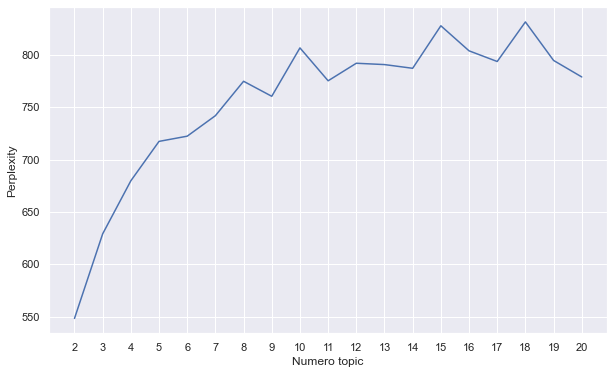

In [51]:
ax = plt.figure(figsize=(10,6))
ax = sns.lineplot(x=range(2, 21), y=perplexity_lda)
ax.set(xticks=list(range(2,21)))
ax.set_xlabel('Numero topic')
ax.set_ylabel('Perplexity')
plt.show()

## CTM perplexity

In [25]:
perplexity_ctm = list() # inizializzazione lista di perplexity per la visualizzazione

for i in range(2, 21):
    # inizializza fold
    kf = KFold(n_splits=5, shuffle=True)
    perplexity_list = list()
    for train_index, test_index in kf.split(unstemmed_documents):
        X_train, X_test = unstemmed_documents[train_index], unstemmed_documents[test_index]
        # creazione corpus tomotopy
        corpus_train = Corpus()
        for doc in X_train:
            corpus_train.add_doc(doc)
        # creazione modello LDA
        ctm_model = CTModel(k=i, smoothing_alpha=50/i, eta=0.1, corpus=corpus_train) # costruzione modello
        ctm_model.burn_in = burn_in_samp #imposta burnin
        ctm_model.train(train_iter)
        # inferenza sui documenti di test
        corpus_test = Corpus()
        for doc in X_test:
            corpus_test.add_doc(doc)
        # calcolo perpleity su test set
        topic_dist, ll = ctm_model.infer(corpus_test)
        num_words = sum(X_test.map(lambda x: len(x)))
        perp = math.exp(-(np.sum(ll)/num_words))
        perplexity_list.append(perp)
    perplexity_ctm.append(np.mean(perplexity_list))
    print('Perplexity media CTM con 5-fold CV con k={}: {}'.format(i, np.mean(perplexity_list)))

Perplexity media CTM con 5-fold CV con k=2: 292.33296081112104
Perplexity media CTM con 5-fold CV con k=3: 228.92992150529486
Perplexity media CTM con 5-fold CV con k=4: 200.02909398951834
Perplexity media CTM con 5-fold CV con k=5: 187.20700990117177
Perplexity media CTM con 5-fold CV con k=6: 170.60798208665562
Perplexity media CTM con 5-fold CV con k=7: 167.57183062268322
Perplexity media CTM con 5-fold CV con k=8: 166.2367874604915
Perplexity media CTM con 5-fold CV con k=9: 157.36881890062787
Perplexity media CTM con 5-fold CV con k=10: 157.34946241354842
Perplexity media CTM con 5-fold CV con k=11: 151.61379279540844
Perplexity media CTM con 5-fold CV con k=12: 154.90316451152378
Perplexity media CTM con 5-fold CV con k=13: 157.34308875172317
Perplexity media CTM con 5-fold CV con k=14: 156.35612763600744
Perplexity media CTM con 5-fold CV con k=15: 154.9600213595605
Perplexity media CTM con 5-fold CV con k=16: 157.8152355987037
Perplexity media CTM con 5-fold CV con k=17: 157.41

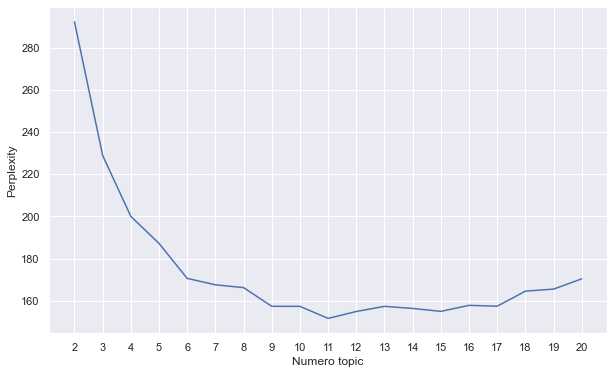

In [52]:
ax = plt.figure(figsize=(10,6))
ax = sns.lineplot(x=range(2, 21), y=perplexity_ctm)
ax.set(xticks=list(range(2,21)))
ax.set_xlabel('Numero topic')
ax.set_ylabel('Perplexity')
plt.show()

## Coherence

In [27]:
from tomotopy.coherence import Coherence

In [28]:
# corpus completo con tutti i documenti
corpus_total = Corpus()
for doc in unstemmed_documents:
    corpus_total.add_doc(doc)

## Coherence LDA

In [29]:
coherence_lda = list() # inizializza lista di coherence per la visualizzazione

for i in range(3, 15):
    # creazione modello LDA e train con tutti i documenti
    lda_model = LDAModel(k=i, alpha=50/i, eta=0.1, seed=12345, corpus=corpus_total) # costruzione modello
    lda_model.burn_in = burn_in_samp #imposta burnin
    lda_model.train(train_iter) # iterazioni di train
    coh = Coherence(lda_model, coherence='c_v')
    average_coherence = coh.get_score()
    coherence_lda.append(average_coherence)
    print('Coherence LDA c_v con k={} = {}'.format(i, average_coherence))

Coherence LDA c_v con k=3 = 0.6020525226990382
Coherence LDA c_v con k=4 = 0.5992245640605689
Coherence LDA c_v con k=5 = 0.4834776374697685
Coherence LDA c_v con k=6 = 0.5292368950943153
Coherence LDA c_v con k=7 = 0.5056845786316054
Coherence LDA c_v con k=8 = 0.5205141740385443
Coherence LDA c_v con k=9 = 0.5933118141359752
Coherence LDA c_v con k=10 = 0.5593857741355897
Coherence LDA c_v con k=11 = 0.5531086721245877
Coherence LDA c_v con k=12 = 0.5754621217337748
Coherence LDA c_v con k=13 = 0.5970124076192196
Coherence LDA c_v con k=14 = 0.6272094247596604


<AxesSubplot:>

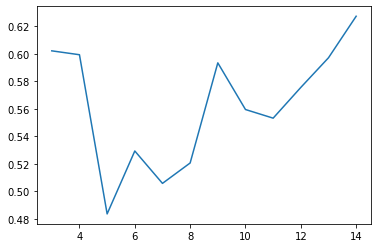

In [30]:
sns.lineplot(x=range(3, 15), y=coherence_lda)

## Coherence CTM

In [31]:
coherence_ctm = list() # inizializza lista di coherence per la visualizzazione

for i in range(3, 15):
    # creazione modello LDA e train con tutti i documenti
    ctm_model = CTModel(k=i, smoothing_alpha=50/i, seed=12345, eta=0.1, corpus=corpus_total) # costruzione modello
    ctm_model.burn_in = burn_in_samp #imposta burnin
    ctm_model.train(train_iter) # iterazioni di train
    coh = Coherence(ctm_model, coherence='c_v')
    average_coherence = coh.get_score()
    coherence_ctm.append(average_coherence)
    print('Coherence CTM c_v con k={} = {}'.format(i, average_coherence))

Coherence CTM c_v con k=3 = 0.34869067668914794
Coherence CTM c_v con k=4 = 0.3881690512411296
Coherence CTM c_v con k=5 = 0.35065642774105077
Coherence CTM c_v con k=6 = 0.34719501331759
Coherence CTM c_v con k=7 = 0.3100120174831578
Coherence CTM c_v con k=8 = 0.3461077481071697
Coherence CTM c_v con k=9 = 0.3514739466624128
Coherence CTM c_v con k=10 = 0.3394014664180577
Coherence CTM c_v con k=11 = 0.3581508822739124
Coherence CTM c_v con k=12 = 0.3328438140131766
Coherence CTM c_v con k=13 = 0.3392330884521541
Coherence CTM c_v con k=14 = 0.3262701625137457


<AxesSubplot:>

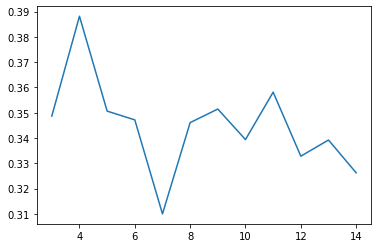

In [32]:
sns.lineplot(x=range(3, 15), y=coherence_ctm)

## Estrazione topic LDA

In [33]:
k=7
lda_model = LDAModel(k=k, alpha=50/k, eta=0.1, seed=12345, corpus=corpus_total) # costruzione modello
lda_model.burn_in = burn_in_samp #imposta burnin

#### Train del modello

In [34]:
lda_model.train(train_iter) # effettua il train

In [35]:
print('Num docs:', len(lda_model.docs), ', Vocab size:', len(lda_model.used_vocabs), ', Num words:', lda_model.num_words)
print('Removed top words:', lda_model.removed_top_words)

Num docs: 259 , Vocab size: 3157 , Num words: 27880
Removed top words: []


In [36]:
for k in range(lda_model.k):
    print('Topic #{}'.format(k))
    for word, prob in lda_model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #0
		security	0.09168034791946411
		attacks	0.02387218549847603
		privacy	0.02170480228960514
		schemes	0.021395176649093628
		sensors	0.016131529584527016
		users	0.013964145444333553
		networks	0.011796761304140091
		mechanism	0.010867882519960403
		nodes	0.010867882519960403
		industry	0.010248629376292229
Topic #1
		control	0.018785156309604645
		optimization	0.01807761751115322
		methods	0.017723847180604935
		access	0.01595500111579895
		performance	0.014539922587573528
		schemes	0.014186153188347816
		transmission	0.013124844990670681
		based	0.012417306192219257
		power	0.011002229526638985
		energy	0.010648459196090698
Topic #2
		industry	0.04789108783006668
		blockchain	0.03119783289730549
		energy	0.0274882223457098
		iiot	0.0274882223457098
		management	0.015246503055095673
		power	0.012278813868761063
		distributed	0.012278813868761063
		production	0.011536892503499985
		buildings	0.011165930889546871
		model	0.009682086296379566
Topic #3
		technology	0.0274088196456

In [37]:
for j in range(0, k+1):
    corpus['Topic_'+str(j)] = pd.Series(np.zeros(len(stemmed_documents)))

In [38]:
for i in range(0, len(corpus['Introduction'])):
    doc = lda_model.make_doc(unstemmed_documents[i])
    x = lda_model.infer(doc)
    for j in range(0, k+1):
        corpus.at[i, 'Topic_'+str(j)] = x[0][j]

In [39]:
pd.set_option('display.max_colwidth', None)

In [40]:
topic_dict = {'Topic_0': 'Industry', 'Topic_1': 'Security', 'Topic_2': 'Smart City', 'Topic_3': 'Machine learning', 
              'Topic_4': 'Communication', 'Topic_5': 'Research and surveys', 'Topic_6': 'Cloud computing'}

In [41]:
corpus = corpus.rename(columns=topic_dict)

In [42]:
corpus['assignedTopic'] = corpus.iloc[:, 6:].idxmax(axis=1)

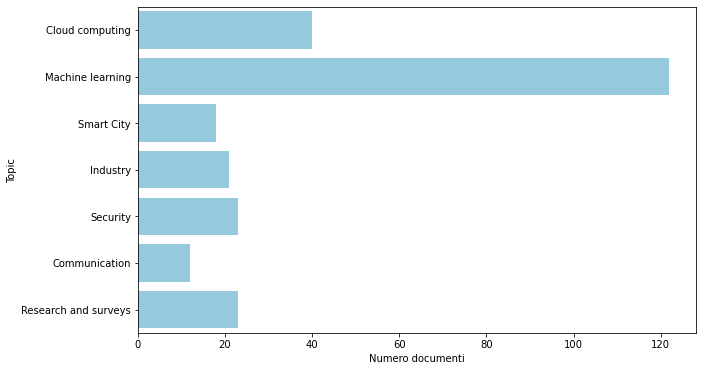

In [43]:
ax = plt.figure(figsize=(10,6))
ax = sns.countplot(y="assignedTopic", data=corpus, color="skyblue")
ax.set_xlabel('Numero documenti')
ax.set_ylabel('Topic')
plt.show()

## Estrazione topic CTM

In [44]:
k = 12
ctm_model = CTModel(k=k, smoothing_alpha=50/k, seed=12345, eta=0.1, corpus=corpus_total) # costruzione modello
ctm_model.burn_in = burn_in_samp #imposta burnin
ctm_model.train(train_iter) # iterazioni di train

In [45]:
print('Num docs:', len(ctm_model.docs), ', Vocab size:', len(ctm_model.used_vocabs), ', Num words:', ctm_model.num_words)
print('Removed top words:', ctm_model.removed_top_words)

Num docs: 259 , Vocab size: 3157 , Num words: 27880
Removed top words: []


In [46]:
for k in range(ctm_model.k):
    print('Topic #{}'.format(k))
    for word, prob in ctm_model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #0
		management	0.040727078914642334
		networks	0.026276761665940285
		big	0.022093774750828743
		finally	0.02095296047627926
		survey	0.016769973561167717
		address	0.016009431332349777
		make	0.015248887240886688
		physical	0.015248887240886688
		importance	0.014868616126477718
		architectures	0.014488344080746174
Topic #1
		computing	0.09445789456367493
		edge	0.05002578720450401
		fog	0.02820645086467266
		needs	0.02304915338754654
		cloud	0.019082000479102135
		model	0.013527987524867058
		access	0.013527987524867058
		related	0.012734557501971722
		evaluation	0.012337842956185341
		concept	0.012337842956185341
Topic #2
		technology	0.06019116938114166
		based	0.0336199589073658
		processing	0.02992951311171055
		using	0.027715245261788368
		emerging	0.020703399553894997
		communication	0.020334353670477867
		solution	0.018120087683200836
		future	0.017012953758239746
		architectures	0.016274863854050636
		cloud	0.015905819833278656
Topic #3
		services	0.05805292725563049
		